# Concept Drift - Deployer
Deploy a streaming Concept Drift detector on a labeled stream.  

This function is the Deployment step for the Streaming Concept Drift Detector.  It will initialize the selected drift detectors with the base_dataset's statistics and deploy the [concept_drift_streaming serverless Nuclio function](../concept_drift_streaming/concept_drift_streaming.ipynb) with them for streaming concept-drift detection on top of a labeled stream.

### **Data exploration**

In [1]:
import pandas as pd
data_path = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/concept_drift/mixed_0101_abrupto.csv'
train_data_path = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/concept_drift/mixed_0101_abrupto_train.csv'
df = pd.read_csv(data_path)

In [2]:
df.head()

,X1,X2,X3,X4,class
0,0.0,1.0,0.460101,0.592744,1.0
1,1.0,1.0,0.588788,0.574984,0.0
2,0.0,0.0,0.401641,0.679325,1.0
3,1.0,1.0,0.306076,0.182108,0.0
4,0.0,0.0,0.962847,0.579245,1.0


### **Setup function parameters**

In [3]:
## Getting a model to monitor concept drift on
import mlrun
mlrun.set_environment(project='function-marketplace')

# Importing sklearn_classifier function from the hub to easy train a model
fn = mlrun.import_function("hub://sklearn_classifier")
fn.apply(mlrun.auto_mount())

> 2021-10-19 11:35:07,696 [info] created and saved project function-marketplace


> 2021-10-19 11:35:08,144 [info] starting run sklearn_classifier uid=cb33a9972b6a48eb9e767ae30020dfc4 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...0020dfc4,0,Oct 19 11:35:08,completed,sklearn_classifier,v3io_user=danikind=owner=danihost=jupyter-dani-6bfbd76d96-zxx6fclass=sklearn.ensemble.RandomForestClassifier,dataset,sample=-1test_size=0.05train_val_split=0.95random_state=1n_jobs=-1label_column=classmodel_pkg_class=sklearn.ensemble.RandomForestClassifier,accuracy=0.9789915966386554test-error=0.02100840336134454rocauc=0.9988698170516352brier_score=0.013172689075630255f1-score=0.978723404255319precision_score=0.9745762711864406recall_score=0.9829059829059829,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


> 2021-10-19 11:35:12,558 [info] run executed, status=completed


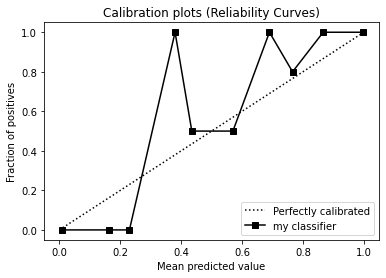

<Figure size 432x288 with 0 Axes>

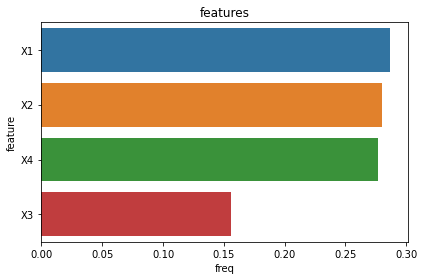

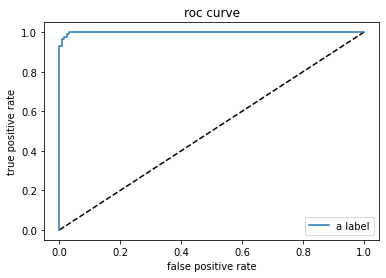

In [4]:
# Training the model

classifier_run = fn.run(name= "sklearn_classifier",
                        params= {"sample"             : -1,
                                 "test_size"          : 0.05,
                                 "train_val_split"    : 0.95,
                                 "random_state"       : 1,
                                 "n_jobs"             : -1,
                                 "label_column"       : 'class',
                                 "model_pkg_class"    : "sklearn.ensemble.RandomForestClassifier"},
                        inputs={"dataset"  : train_data_path},
                        local=True)

In [16]:
# Getting the model

from mlrun.artifacts import get_model
import pickle

model_file, model_obj, _ = get_model(classifier_run.artifact('model'))
model = pickle.load(open(model_file,'rb'))

In [18]:
pickle.dump(model, open('concept_drift_random_forest.pkl', 'wb'))

In [7]:
predicted_train = df[:5000].copy()
predicted_train['predicted_col'] = model.predict(predicted_train.drop(['class'],axis=1))

In [8]:
# Importing the function

fn = mlrun.import_function("hub://concept_drift")
fn.apply(mlrun.auto_mount())

In [9]:
predicted_train_path = 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/concept_drift/predicted_abrupto_train.csv'

In [10]:
import v3io.dataplane
import os 

container = os.path.join('/',os.environ['V3IO_HOME'].split('/')[0])
user = os.environ["V3IO_USERNAME"]
rel_path = os.getcwd()[6:] + '/artifacts'
cwd = os.path.join(container,user,rel_path)
base_input_stream = os.path.join(user,rel_path) + "/inputs_stream"
input_stream = os.path.join(container,base_input_stream)
output_stream = os.path.join(container,user,rel_path) + "/output_stream"
tsdb_path = os.path.join(container,user,rel_path) + "/output_tsdb"
stream_consumer_group = 'cd'
http_input_stream = f'http://{os.environ["V3IO_API"]}{input_stream}@{stream_consumer_group}'


# input_stream = cwd+"/inputs_stream"
# base_input_stream = os.environ['V3IO_USERNAME'] + "/" + os.getcwd()[6:]+"/inputs_stream"
# input_stream_path = cwd+'/input_stream'
# output_stream_path = cwd+'/output_stream'
# tsdb_path = cwd+'/tsdb_stream'




client = v3io.dataplane.Client()
response = client.stream.create(container = container,
                                stream_path=base_input_stream,
                                shard_count=1,
                                raise_for_status = v3io.dataplane.RaiseForStatus.never)
response.raise_for_status([409, 204])

In [11]:
fn.run(name='concept_drift',
       params={'input_stream'    : http_input_stream,
               'output_stream'   : output_stream,
               'output_tsdb'     : tsdb_path,
               'tsdb_batch_size' : 300,
               'models'          : ['ddm', 'eddm', 'pagehinkley'], # defaults
               'label_col'       : 'class',
               'prediction_col'  : 'predicted_col'},
       inputs={'base_dataset'    : predicted_train_path},
       artifact_path = os.path.join(os.getcwd(), 'artifacts'),
       local=True)

> 2021-10-19 11:35:13,470 [info] starting run concept_drift uid=c990eecf046f4f008135d35ccde218c4 DB=http://mlrun-api:8080
> 2021-10-19 11:35:14,437 [info] Loading base dataset
> 2021-10-19 11:35:15,698 [info] Creating models
> 2021-10-19 11:35:15,699 [info] Streaming data to models
> 2021-10-19 11:35:15,828 [info] Logging ready models
> 2021-10-19 11:35:15,999 [info] Deploying Concept Drift Streaming function
> 2021-10-19 11:35:16,002 [info] Starting remote function deploy
2021-10-19 11:35:16  (info) Deploying function
2021-10-19 11:35:16  (info) Building
2021-10-19 11:35:16  (info) Staging files and preparing base images
2021-10-19 11:35:16  (info) Building processor image
2021-10-19 11:35:17  (info) Build complete
2021-10-19 11:35:23  (info) Function deploy complete
> 2021-10-19 11:35:24,077 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-function-marketplace-concept-drift-streaming.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['de

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
function-marketplace,...cde218c4,0,Oct 19 11:35:14,completed,concept_drift,v3io_user=danikind=owner=danihost=jupyter-dani-6bfbd76d96-zxx6f,base_dataset,"input_stream=http://v3io-webapi.default-tenant.svc:8081/users/dani/test/functions/concept_drift/artifacts/inputs_stream@cdoutput_stream=/users/dani/test/functions/concept_drift/artifacts/output_streamoutput_tsdb=/users/dani/test/functions/concept_drift/artifacts/output_tsdbtsdb_batch_size=300models=['ddm', 'eddm', 'pagehinkley']label_col=classprediction_col=predicted_col",,eddm_concept_driftpagehinkley_concept_driftddm_concept_drift


> 2021-10-19 11:35:24,239 [info] run executed, status=completed


In [12]:
import json

def restructure_stream_event(context, event):
    instances = [dict()]
    for key in predicted_train.keys():
        if key not in ['when', 'class', 'model', 'worker', 'hostname', 'predicted_col']:
            instances[0].update({key: event.pop(key)})
    event['request'] = {'instances': instances}
    event['resp'] = [int(event.pop('predicted_col'))]
    return event
    
    
records = json.loads(predicted_train.to_json(orient='records'))
records = [{'data': json.dumps(restructure_stream_event(context, record))} for record in records]

In [13]:
records[0]

{'data': '{"class": 1.0, "request": {"instances": [{"X1": 0.0, "X2": 1.0, "X3": 0.4601012282, "X4": 0.592744409}]}, "resp": [1]}'}

In [14]:
# batch

# v3io_client = v3io.dataplane.Client(logger_verbosity='DEBUG', transport_verbosity='DEBUG')
# step = 10
# for idx in range(0, len(records), step):
#     response = v3io_client.put_records(container=container,
#                                        path=base_input_stream, 
#                                        records=records[idx:idx+step])
    

In [15]:
ssssssssss

NameError: name 'ssssssssss' is not defined

## Local test
A usecase based run example

In [ ]:
from mlrun import run_local, NewTask

In [ ]:
container = 'bigdata'
base_table = os.path.join('/', container, 'network-operations')
stream_consumer_group = 'cd'
artifacts_path = os.path.join(os.getcwd(), 'artifacts')

task = NewTask(name='concept_drift_deployer',
        project='network-operations',
        handler=concept_drift_deployer,
        params={'models': ['ddm', 'eddm', 'pagehinkley'],
                'label_col': 'is_error',
                'prediction_col': 'yscore',
                'output_tsdb': os.path.join(base_table, 'drift_tsdb'),
                'input_stream': f'http://{os.environ["V3IO_API"]}{os.path.join(base_table, 'inference_stream')}@{stream_consumer_group}',
                'output_stream': os.path.join(base_table, 'drift_stream')},
        inputs={'base_dataset': 'store://network-operations/test_test_set_preds'},
        artifact_path=artifacts_path)

In [ ]:
artifacts_path = os.path.join(os.getcwd(), 'artifacts')
artifacts_path

In [ ]:
run_local(task)

## Save function yaml

In [ ]:
from os import path
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io, code_to_function
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

In [ ]:
# create job function object from notebook code
fn = code_to_function("concept_drift", 
                      kind='job',
                      with_doc=True,
                      embed_code=True)

# add metadata (for templates and reuse)
fn.spec.default_handler = "concept_drift_deployer"
fn.spec.description = "Deploy a streaming Concept Drift detector on a labeled stream"
fn.metadata.categories = ["ml", "serve"]
fn.metadata.labels = {"author": "orz", "framework": "sklearn"}
fn.export("function.yaml")

In [ ]:
fn.apply(mount_v3io())

## Stream testing

In [ ]:
fn.deploy()

In [ ]:
fn.run(task)